In [1]:
"""
This is the module the detects vehicles in images
"""
import os
import glob
import time
import pickle
import logging as log
import matplotlib.image as mpimg
import numpy as np
import cv2
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt


class VehicleDetection:
    """
    Main class for vehicle detection pipeline
    """
    def __init__(self):
        self.clf = None
        self.scaler = None
        self.color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 9  # HOG orientations
        self.pix_per_cell = 8 # HOG pixels per cell
        self.cell_per_block = 2 # HOG cells per block
        self.hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
        self.spatial_size = (32, 32) # Spatial binning dimensions
        self.hist_bins = 32    # Number of histogram bins
        self.spatial_feat = True # Spatial features on or off
        self.hist_feat = True # Histogram features on or off
        self.hog_feat = True # HOG features on or off
        self.bins_range=(0, 256)

        root_dir = os.path.dirname('.')
        self.clf_pkl = root_dir + 'clf.pkl'
        self.scaler_pkl = root_dir + 'scaler.pkl'
        log.debug('pickle files ' + self.clf_pkl + ' and ' + self.scaler_pkl)
        if os.path.exists(self.clf_pkl) and os.path.exists(self.scaler_pkl):
            log.info('loading classifier and scaler from pickle files')
            with open(self.clf_pkl, 'rb') as input:
                self.clf = pickle.load(input)
            with open(self.scaler_pkl, 'rb') as input:
                self.scaler = pickle.load(input)


    def __bin_spatial(self, img):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, self.spatial_size).ravel()
        # Return the feature vector
        return features

    def __color_hist(self, img):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=self.hist_bins, range=self.bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=self.hist_bins, range=self.bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=self.hist_bins, range=self.bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features

    # Define a function to return HOG features and visualization
    def __get_hog_features(self, img, vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(
                img, orientations=self.orient, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                cells_per_block=(self.cell_per_block, self.cell_per_block), transform_sqrt=True,
                visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:
            features = hog(
                img, orientations=self.orient, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                cells_per_block=(self.cell_per_block, self.cell_per_block), transform_sqrt=True,
                visualise=vis, feature_vector=feature_vec)
            return features

    def __single_img_features(self, img):
        #1) Define an empty list to receive features
        img_features = []
        #2) Apply color conversion if other than 'RGB'
        if self.color_space != 'RGB':
            if self.color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif self.color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif self.color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif self.color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif self.color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)

        #3) Compute spatial features if flag is set
        if self.spatial_feat:
            spatial_features = self.__bin_spatial(feature_image)
            #4) Append features to list
            img_features.append(spatial_features)
        #5) Compute histogram features if flag is set
        if self.hist_feat:
            hist_features = self.__color_hist(feature_image)
            #6) Append features to list
            img_features.append(hist_features)
        #7) Compute HOG features if flag is set
        if self.hog_feat:
            if self.hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(self.__get_hog_features(feature_image[:,:,channel]))
            else:
                hog_features = self.__get_hog_features(feature_image[:,:,self.hog_channel])
            #8) Append features to list
            img_features.append(hog_features)

        #9) Return concatenated array of features
        return np.concatenate(img_features)

    def __extract_features(self, imgs):
        features = []
        for file in imgs:
            image = mpimg.imread(file)
            img_features = self.__single_img_features(image)
            features.append(img_features)
        return features

    def fit(self, datasets_path, force=False):
        log.info('classifying with datasets on ' + datasets_path)

        if self.clf and self.scaler and not force:
            log.info('classifier appears to already be trained')
            return

        carsgen = glob.iglob(datasets_path + '/vehicles/**/*.jpeg', recursive=True)
        notcarsgen = glob.iglob(datasets_path + '/non-vehicles/**/*.jpeg', recursive=True)
        cars = [car for car in carsgen]
        notcars = [notcar for notcar in notcarsgen]

        log.info('ncars ' + str(len(cars)))
        log.info('nnotcars ' + str(len(notcars)))

        self.color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 9  # HOG orientations
        self.pix_per_cell = 8 # HOG pixels per cell
        self.cell_per_block = 2
        self.hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
        self.spatial_size = (32, 32)
        self.hist_bins = 32
        self.spatial_feat = True
        self.hist_feat = True
        self.hog_feat = True
        self.bins_range=(0, 256)

        car_features = self.__extract_features(cars)
        notcar_features = self.__extract_features(notcars)

        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        # Use a linear SVC
        svc = LinearSVC()

        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        log.info(str(t2-t) + ' seconds to train SVC...')
        # Check the score of the SVC
        log.info('Train Accuracy of SVC = ' + str(svc.score(X_train, y_train)))
        log.info('Test Accuracy of SVC = ' + str(svc.score(X_test, y_test)))
        print('Test Accuracy of SVC = ' + str(svc.score(X_test, y_test)))
        # Check the prediction time for a single sample
        t=time.time()
        prediction = svc.predict(X_test[0].reshape(1, -1))
        t2 = time.time()
        log.info(str(t2-t) + ' seconds to predict with SVC')
        self.clf = svc
        self.scaler = X_scaler

        with open(self.clf_pkl, 'wb') as output:
            log.info('saving ' + self.clf_pkl)
            pickle.dump(self.clf, output, pickle.HIGHEST_PROTOCOL)

        with open(self.scaler_pkl, 'wb') as output:
            log.info('saving ' + self.scaler_pkl)
            pickle.dump(self.scaler, output, pickle.HIGHEST_PROTOCOL)


    def __slide_window(self, img, x_start_stop=[None, None], y_start_stop=[None, None],
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img.shape[0]
        # Compute the span of the region to be searched
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]

        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

        # Compute the number of windows in x/y
        nx_windows = np.int(xspan/nx_pix_per_step)
        ny_windows = np.int(yspan/ny_pix_per_step) - 1
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]

                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list

    def __get_default_windows(self, img):

        # extra large boxes
        xl_windows = self.__slide_window(
            img, x_start_stop=[30, 1250], y_start_stop=[375, 675],
            xy_window=(300, 300), xy_overlap=(0.9, 0.8))

        # large boxes
        l_windows = self.__slide_window(
            img, x_start_stop=[50, 1200], y_start_stop=[400, 600],
            xy_window=(200, 200), xy_overlap=(0.9, 0.8))

        # medium boxes
        m_windows = self.__slide_window(
            img, x_start_stop=[150, 1050], y_start_stop=[375, 600],
            xy_window=(150, 150), xy_overlap=(0.9, 0.8))

        # small boxes
        s_windows = self.__slide_window(
            img, x_start_stop=[300, 1000], y_start_stop=[375, 450],
            xy_window=(75, 75), xy_overlap=(0.9, 0.8))

        windows = xl_windows + l_windows + m_windows + s_windows
        # windows = m_windows
        return s_windows

    def __search_windows(self, img, windows):
        on_windows = []
        for window in windows:
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
            features = self.__single_img_features(test_img)
            test_features = self.scaler.transform(np.array(features).reshape(1, -1))
            prediction = self.clf.predict(test_features)
            if prediction == 1:
                on_windows.append(window)
        return on_windows

    def detect_vehicles(self, img):
        """
        Main method to detect vehicles.
        It receives an image and if returns coordinates
        of the potential vehicles after the overlap.
        False positives should be detected by the vehicle tracking class
        """
        default_windows = self.__get_default_windows(img)
        hot_windows = self.__search_windows(img, default_windows)
        return hot_windows, default_windows

    def path_to_prediction(self, path):
        img = mpimg.imread(path)
        test_img = cv2.resize(img, (64, 64))
        features = self.__single_img_features(test_img)
        test_features = self.scaler.transform(np.array(features).reshape(1, -1))
        prediction = self.clf.predict(test_features)
        return prediction

In [2]:
vehicle_detection = VehicleDetection()
vehicle_detection.fit('../datasets/', force=False)

Test Accuracy of SVC = 0.99161308359


../datasets/non-vehicles/GTI/image1341.jpeg


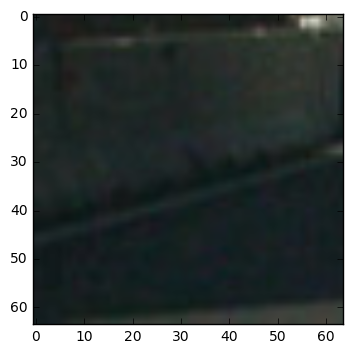

../datasets/non-vehicles/GTI/image824.jpeg


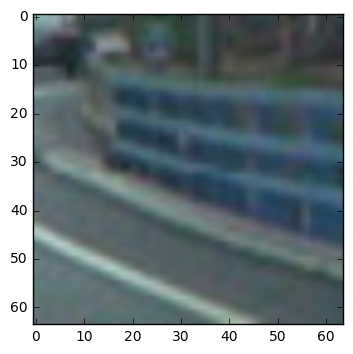

../datasets/non-vehicles/GTI/image379.jpeg


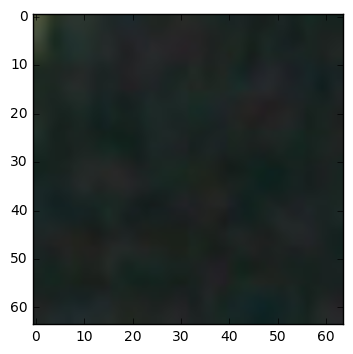

../datasets/non-vehicles/GTI/image3281.jpeg


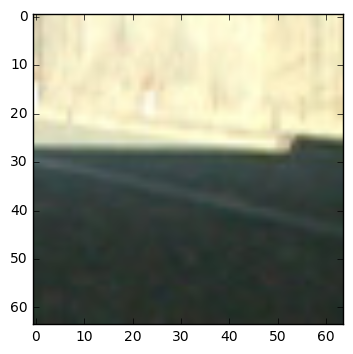

../datasets/non-vehicles/GTI/image2241.jpeg


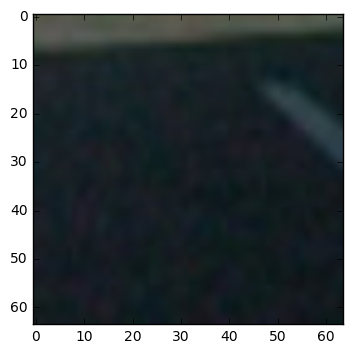

../datasets/non-vehicles/Extras/extra5645.jpeg


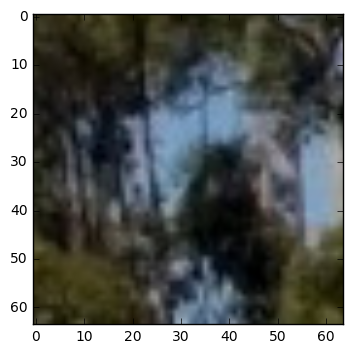

../datasets/non-vehicles/Extras/extra3796.jpeg


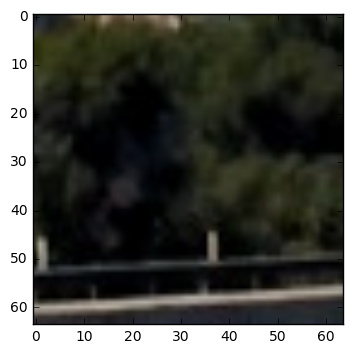

../datasets/non-vehicles/Extras/extra5096.jpeg


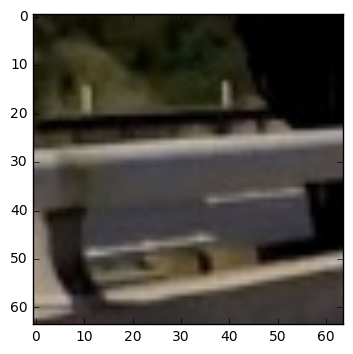

../datasets/non-vehicles/Extras/extra1610.jpeg


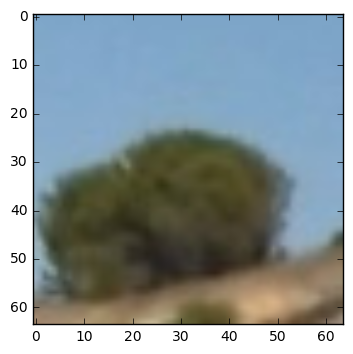

../datasets/non-vehicles/Extras/extra3445.jpeg


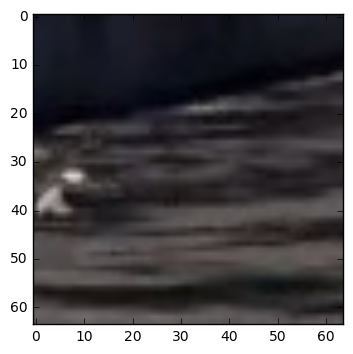

In [3]:
outliers = glob.iglob('../datasets/non-vehicles/**/*.jpeg', recursive=True)
for outlier in outliers:
    prediction = vehicle_detection.path_to_prediction(outlier)
    if prediction == 1:
        print(outlier)
        img = mpimg.imread(outlier)
        plt.imshow(img)
        plt.show()

../datasets/vehicles/GTI_MiddleClose/image0209.jpeg


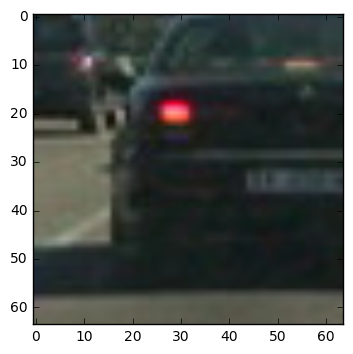

../datasets/vehicles/GTI_MiddleClose/image0257.jpeg


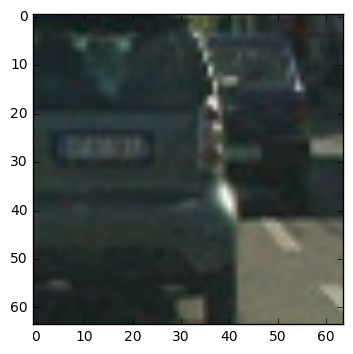

../datasets/vehicles/GTI_Left/image0449.jpeg


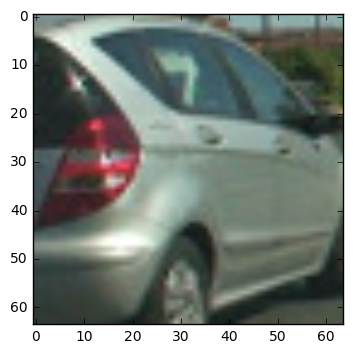

../datasets/vehicles/GTI_Left/image0457.jpeg


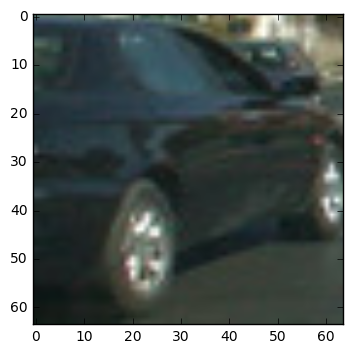

../datasets/vehicles/GTI_Left/image0524.jpeg


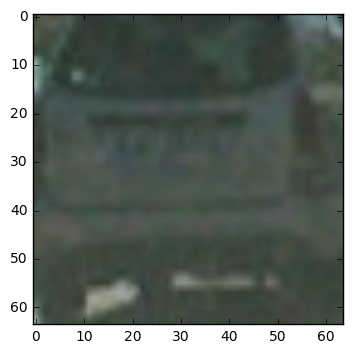

../datasets/vehicles/GTI_Right/image0291.jpeg


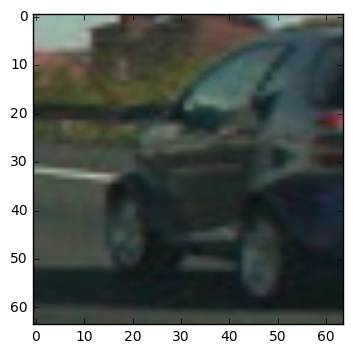

../datasets/vehicles/GTI_Right/image0719.jpeg


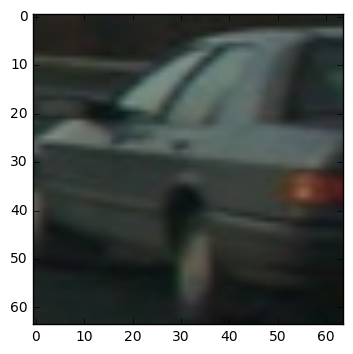

../datasets/vehicles/GTI_Right/image0089.jpeg


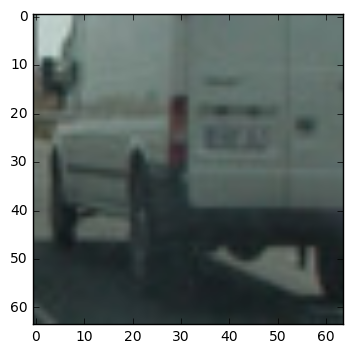

../datasets/vehicles/KITTI_extracted/2593.jpeg


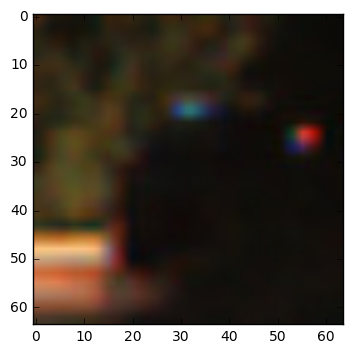

../datasets/vehicles/KITTI_extracted/4597.jpeg


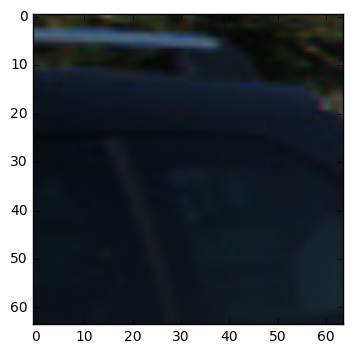

../datasets/vehicles/KITTI_extracted/2534.jpeg


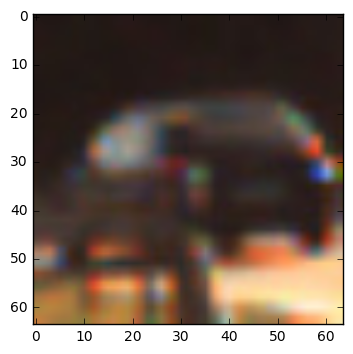

../datasets/vehicles/KITTI_extracted/1852.jpeg


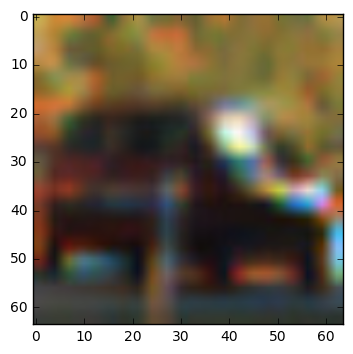

../datasets/vehicles/KITTI_extracted/181.jpeg


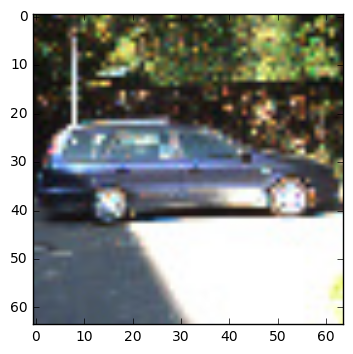

../datasets/vehicles/KITTI_extracted/4863.jpeg


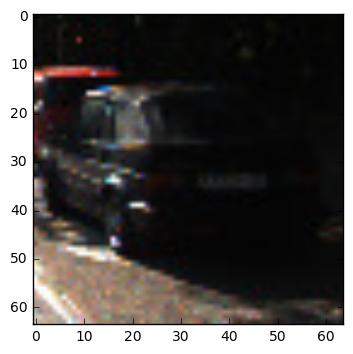

../datasets/vehicles/KITTI_extracted/2123.jpeg


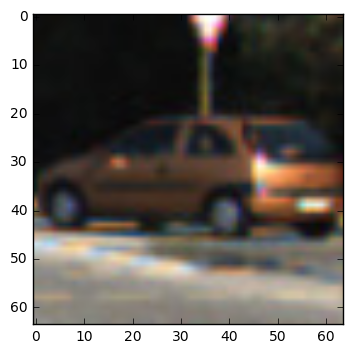

../datasets/vehicles/KITTI_extracted/3507.jpeg


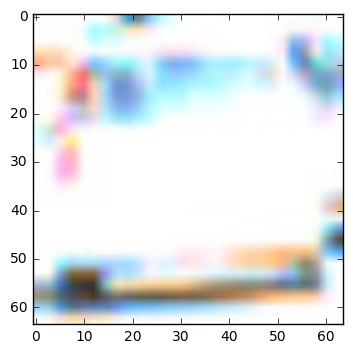

../datasets/vehicles/KITTI_extracted/4563.jpeg


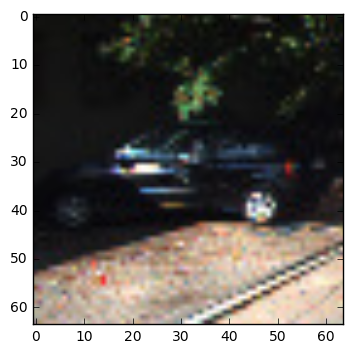

../datasets/vehicles/KITTI_extracted/1656.jpeg


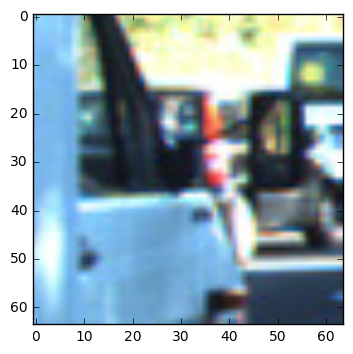

../datasets/vehicles/KITTI_extracted/3980.jpeg


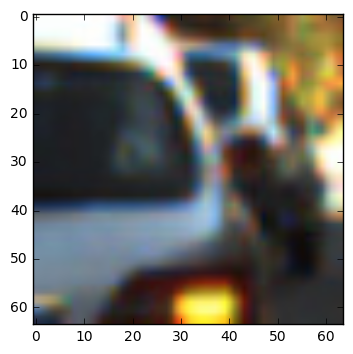

../datasets/vehicles/GTI_Far/image0109.jpeg


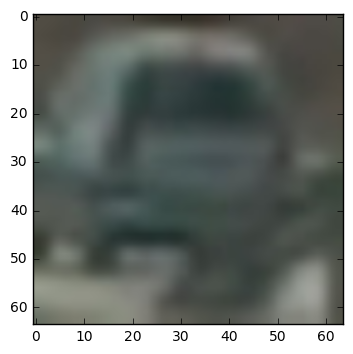

In [4]:
outliers = glob.iglob('../datasets/vehicles/**/*.jpeg', recursive=True)
for outlier in outliers:
    prediction = vehicle_detection.path_to_prediction(outlier)
    if prediction == 0:
        print(outlier)
        img = mpimg.imread(outlier)
        plt.imshow(img)
        plt.show()